### 1. Import Package and Data

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [89]:
df_1999 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2012 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_2014 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_2016 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_2017 = pd.read_csv("../data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

### 2. Data Cleaning

In [90]:
# Checking for NaNs and duplicates
def clean_dataset(df, dataset_name):
    """
    Cleans the dataset by identifying and removing duplicate rows and checking for missing values.

    Parameters:
    df (pd.DataFrame): The DataFrame to be cleaned.
    dataset_name (str): The name of the dataset for logging purposes.

    Returns:
    pd.DataFrame: A cleaned DataFrame with duplicates removed.
    
    Prints:
    - The number of duplicate rows found and removed.
    - The count of missing values per column.
    """
    print(f"Cleaning dataset: {dataset_name}")
    
    # Check for duplicates
    duplicates_count = df.duplicated().sum()
    print(f"{dataset_name}: Number of duplicates: {duplicates_count}")
    
    # Drop duplicates
    df_cleaned = df.drop_duplicates().copy()          
    
    # Check for missing values
    missing_values = df_cleaned.isna().sum()
    print(f"{dataset_name}: Missing values per column:")
    print(missing_values)
    
    return df_cleaned

In [91]:
# Clean each dataset

# 1. Clean and split df_1999
df_1999_cleaned = clean_dataset(df_1999, "1999")

# 2. Clean and split df_2012
df_2012_cleaned = clean_dataset(df_2012, "2012")

# 3. Clean and split df_2014
df_2014_cleaned = clean_dataset(df_2014, "2014")

# 4. Clean and split df_2016
df_2016_cleaned = clean_dataset(df_2016, "2016")

# 5. Clean and split df_2017
df_2017_cleaned = clean_dataset(df_2017, "2017")


Cleaning dataset: 1999
1999: Number of duplicates: 826
1999: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2012
2012: Number of duplicates: 513
2012: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2014
2014: Number of duplicates: 248
2014: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_comm

Our dataset do not contain any missing values. Hence, we will only remove the duplicates.

In [92]:
# Function to print out all the columns in each datasets
def explore_columns(datasets):
    """
    Prints the column names of each dataset in the provided dictionary for exploration and comparison.

    Parameters:
    datasets (dict): A dictionary where keys are dataset names (str) and values are DataFrames (pd.DataFrame).

    Prints:
    - The name and column names of each dataset, separated by a newline for clarity.
    
    This function is useful for identifying column discrepancies or exploring the structure of each dataset
    in a collection.
    """
    for name, df in datasets.items():
        print(f"Dataset {name} columns:")
        print(df.columns)
        print("\n")

In [93]:
# check if all the datasets have the same columns
datasets = {
    "1999": df_1999_cleaned,
    "2012": df_2012_cleaned,
    "2014": df_2014_cleaned,
    "2016": df_2016_cleaned,
    "2017": df_2017_cleaned
}
explore_columns(datasets)

Dataset 1999 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2012 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2014 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2016 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')


Dataset 2017 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
     

We can see that only the 2016 and 2017 contains the column `remaining_lease`. Hence, we will be imputing this value by calculating using `Month` - `Lease commence date`

In [94]:
def impute_remaining_lease(df):
    """
    Imputes 'remaining_lease' based on 'lease_commence_date' and 'Month' columns,
    assuming a 99-year lease duration. Converts the result to an integer by rounding
    based on months: rounds up if months > 6, otherwise rounds down.

    Parameters:
    df (pd.DataFrame): The DataFrame where 'remaining_lease' needs to be imputed.

    Returns:
    pd.DataFrame: The DataFrame with 'remaining_lease' imputed as an integer.
    """
    # Calculate remaining lease as a string with years and months
    df['current_year'] = pd.to_datetime(df['month']).dt.year
    df['remaining_lease'] = (99 - (df['current_year'] - df['lease_commence_date'])).astype(str) + " years 00 months"
    
    # Define the function to convert to integer years with rounding
    def round_remaining_lease(lease):
        match = re.match(r"(\d+) years (\d+) months", lease)
        if match:
            years = int(match.group(1))
            months = int(match.group(2))
            # Round up if months > 6
            if months > 6:
                years += 1
            return years
        else:
            return None

    # Apply rounding to 'remaining_lease' column
    df['remaining_lease'] = df['remaining_lease'].apply(round_remaining_lease)
    
    # Drop the temporary 'current_year' column after imputation
    df.drop(columns=['current_year'], inplace=True)
    return df

In [95]:
# Apply to the datasets where 'remaining_lease' is missing
df_1999_cleaned = impute_remaining_lease(df_1999_cleaned)
df_2012_cleaned = impute_remaining_lease(df_2012_cleaned)
df_2014_cleaned = impute_remaining_lease(df_2014_cleaned)

In addition, some of the `remaining_lease` are string because they are stored in year, month format. For example, 95 years 07 months. We will convert it to only integer years. If month > June, we will round up. Else, we will round down.

In [96]:
def standardize_remaining_lease(df):
    """
    Standardizes the 'remaining_lease' column in a DataFrame to integer years.
    Converts from 'XX years YY months' format to integer years, rounding up if months > 6.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the 'remaining_lease' column in mixed formats.

    Returns:
    pd.DataFrame: The DataFrame with 'remaining_lease' standardized as an integer number of years.
    """
    def convert_lease(lease):
        # If the value is already an integer, return it as-is
        if isinstance(lease, int):
            return lease
        
        # Use regex to extract years and months if lease is in string format
        match = re.match(r"(\d+) years (\d+) months", lease)
        if match:
            years = int(match.group(1))
            months = int(match.group(2))
            
            # Round up if months > 6, otherwise round down
            return years + 1 if months > 6 else years
        return None  # Return None if the format is unexpected
    
    # Apply the conversion directly to the 'remaining_lease' column
    df['remaining_lease'] = df['remaining_lease'].apply(convert_lease)
    return df

In [97]:
# Apply the function to standardize 'remaining_lease' in each cleaned dataset
df_1999_cleaned = standardize_remaining_lease(df_1999_cleaned)
df_2012_cleaned = standardize_remaining_lease(df_2012_cleaned)
df_2014_cleaned = standardize_remaining_lease(df_2014_cleaned)
df_2016_cleaned = standardize_remaining_lease(df_2016_cleaned)
df_2017_cleaned = standardize_remaining_lease(df_2017_cleaned)

### 3. EDA

We will split it into numerical and categorical data

In [98]:
# Splitting categorical and numerical values
def split_categorical_numerical(df):
    """
    Splits the DataFrame into separate categorical and numerical DataFrames based on column data types.

    Parameters:
    df (pd.DataFrame): The DataFrame to be split.

    Returns:
    tuple: A tuple containing two DataFrames:
        - categorical_columns (pd.DataFrame): DataFrame of categorical columns.
        - numerical_columns (pd.DataFrame): DataFrame of numerical columns.
    """
    categorical_columns = df.select_dtypes(include=['object'])
    numerical_columns = df.select_dtypes(include=['number'])
    return categorical_columns, numerical_columns

In [99]:
# 1. split df_1999
df_1999_col, df_1999_num = split_categorical_numerical(df_1999_cleaned)

# 2. split df_2012
df_2012_col, df_2012_num = split_categorical_numerical(df_2012_cleaned)

# 3. split df_2014
df_2014_col, df_2014_num = split_categorical_numerical(df_2014_cleaned)

# 4. split df_2016
df_2016_col, df_2016_num = split_categorical_numerical(df_2016_cleaned)

# 5. split df_2017
df_2017_col, df_2017_num = split_categorical_numerical(df_2017_cleaned)


##### 3.1 Numerical values

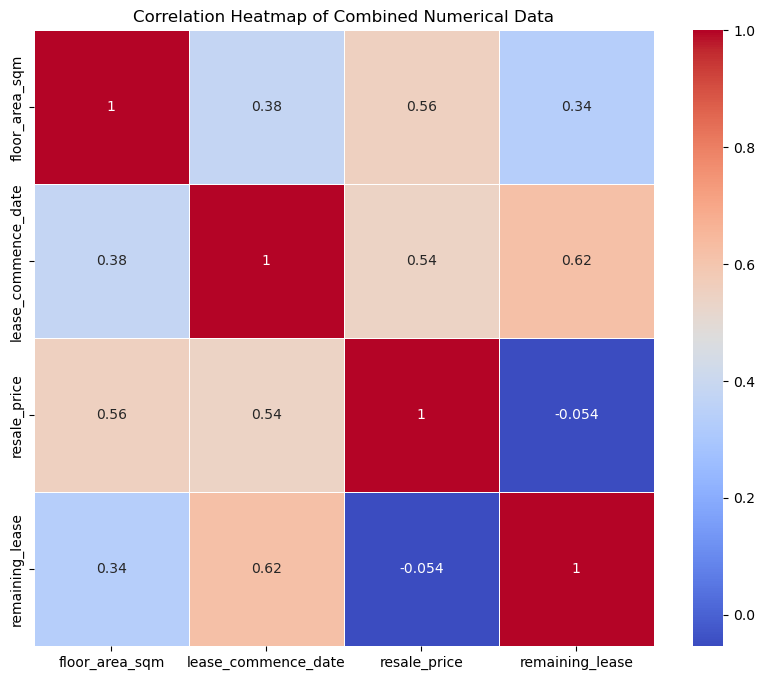

In [100]:
# creating a heat map of the numerical values
numerical_combined = pd.concat([df_1999_num, df_2012_num, df_2014_num, df_2016_num, df_2017_num])
correlation_matrix = numerical_combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Combined Numerical Data')
plt.show()

Considering `remaining_lease` if derived from `lease_commence_date` and they have a rather high correlation (**0.64**), we will drop `lease_commence_date` to keep the more insightful feature `remaining_lease`.

In [101]:
def drop_lease_commence(df):
    """
    Drops the 'lease_commence_date' column from the DataFrame if it exists, to retain only 'remaining_lease'.

    Parameters:
    df (pd.DataFrame): The DataFrame from which 'lease_commence_date' will be removed.

    Returns:
    pd.DataFrame: The DataFrame without the 'lease_commence_date' column if it was present.
    """
    return df.drop(columns=['lease_commence_date'], errors='ignore')

# Example usage on multiple incoming DataFrames
df_1999_cleaned = drop_lease_commence(df_1999_cleaned)
df_2012_cleaned = drop_lease_commence(df_2012_cleaned)
df_2014_cleaned = drop_lease_commence(df_2014_cleaned)
df_2016_cleaned = drop_lease_commence(df_2016_cleaned)
df_2017_cleaned = drop_lease_commence(df_2017_cleaned)

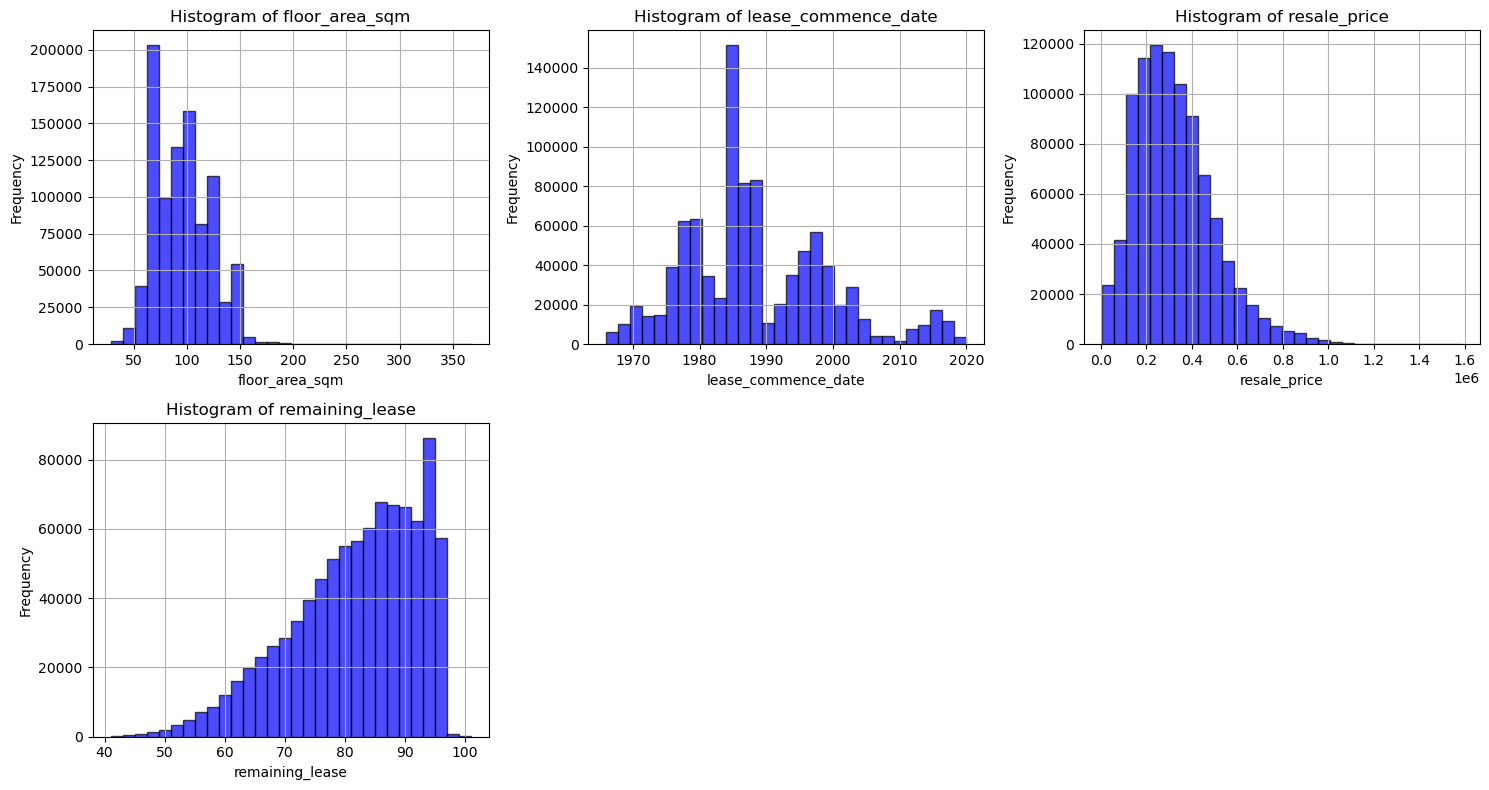

In [103]:
# Define the number of columns and rows for the grid layout
num_columns = 3  # Number of plots per row
num_plots = 4  # Total number of plots
num_rows = 2  # Number of rows needed
numerical_columns = numerical_combined.columns

# Set the figure size
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Plot each numerical column in a subplot
for i, column in enumerate(numerical_columns):
    axes[i].hist(numerical_combined[column], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout to avoid overlapping text
plt.show()

##### 3.2 Categorical values

### 3. Feature Engineering

#### Train_test_split
We will be spliting the data into 80-20 before we conduct any imputation or feature engineering.

In [44]:
# Combining the datasets
combined_data = pd.concat([df_1999_cleaned, df_2012_cleaned, df_2014_cleaned, df_2016_cleaned, df_2017_cleaned], ignore_index=True)

X = combined_data.drop(columns=['resale_price']) 
y = combined_data['resale_price']

# Split the data into an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Standardisation

<span style="font-size: 14px;"> `clean_flat_model` convert all `str` to uppercase and strip whitespaces left and right </span>

<span style="font-size: 14px;">  `convert_remaining_lease` convert the types(`timedelta`, `int` and `str`) into `float` type </span>

<span style="font-size: 14px;">  `convert_month_to_datetime` convert `month` column from `str` to `datetime` </span>

In [7]:
def clean_flat_model(df):
    df['flat_model'] = df['flat_model'].str.strip().str.upper()
    return df 


def convert_remaining_lease(df):
    # When input is a dataframe
    if isinstance(df, pd.DataFrame):
        for index, row in df.iterrows():
            # Convert remaining_lease that are string to float
            if isinstance(row['remaining_lease'], str):
                remaining_lease_str = row["remaining_lease"].lower()
                years = 0
                months = 0
                
                if 'years' in remaining_lease_str:
                    years = int(remaining_lease_str.split('years')[0].strip())
                if 'months' in remaining_lease_str:
                    months = int(remaining_lease_str.split('months')[0].split()[-1].strip())
                df.loc[index, 'remaining_lease'] = years + months / 12
            
            # convert remaining_lease that are timedelta to float, needed for the function(filling of remaining_lease)
            elif isinstance(row['remaining_lease'], pd.Timedelta):
                df.loc[index, 'remaining_lease'] = float(row['remaining_lease'].days / 365)

            # convert remaining_lease that are int to float
            elif isinstance(row['remaining_lease'], int):
                df.loc[index, 'remaining_lease'] = float(row['remaining_lease'])
        return df
    
    # When input is single value
    # Convert remaining_lease that are string to float
    elif isinstance(df, str):
        remaining_lease_str = df.lower()
        years = 0
        months = 0
        
        if 'years' in remaining_lease_str:
            years = int(remaining_lease_str.split('years')[0].strip())
        if 'months' in remaining_lease_str:
            months = int(remaining_lease_str.split('months')[0].split()[-1].strip())
        return years + months / 12
    
    # convert remaining_lease that are timedelta to float, needed for code below(filling of remaining_lease)
    elif isinstance(df, pd.Timedelta):
        return float(df.days / 365)

    # convert remaining_lease that are int to float
    elif isinstance(df, int):
        return float(df)

    # if df is None or other type, return original value
    else:
        return df
    
def convert_month_to_datetime(df, column_name='month'):
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m', errors='coerce')
    return df
    


#### Data Preparation

<span style="font-size: 14px;"> `split_storey_range` add in the columns of `lower_storey` and `upper_storey` derived from  `storey_range` </span>

<span style="font-size: 14px;"> `split_month_column` add in the columns of `year` and `month_number` derived from `month`</span>

<span style="font-size: 14px;"> `add_max_storey` add in the column `max_storey` for each building (at the very least the highest storey recorded)</span>

<span style="font-size: 14px;">  `adjust_remaining_lease` fill up as many missing values in `remaining_lease` using information from buildings that have values in `remaining_lease`</span>

<span style="font-size: 14px;">  add price/square meter </span>

In [8]:
def split_storey_range(df):
    """
    Splits the 'storey_range' column into 'lower_storey' and 'upper_storey'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the 'storey_range' column.
    
    Returns:
    pd.DataFrame: Modified DataFrame with 'lower_storey' and 'upper_storey' columns added.
    """
    # Splitting the 'storey_range' column into 'lower_storey' and 'upper_storey'
    df[['lower_storey', 'upper_storey']] = df['storey_range'].str.split(' TO ', expand=True)

    # Convert lower_storey and upper_storey to numeric types
    df['lower_storey'] = pd.to_numeric(df['lower_storey'], errors='coerce')
    df['upper_storey'] = pd.to_numeric(df['upper_storey'], errors='coerce')

    return df

def split_month_column(df):
    """
    Splits the 'month' column into 'year' and 'month_number'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the 'month' column.
    
    Returns:
    pd.DataFrame: Modified DataFrame with 'year' and 'month_number' columns added.
    """
    # Splitting the 'month' column into 'year' and 'month_number'
    df['year'] = pd.to_datetime(df['month']).dt.year
    df['month_number'] = pd.to_datetime(df['month']).dt.month

    return df

def add_max_storey(df):
    """
    Adds a column 'max_storey' to the DataFrame based on the maximum upper_storey 
    for each unique combination of town, block, and street_name.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'town', 'block', 'street_name', and 'upper_storey'.

    Returns:
    pd.DataFrame: Modified DataFrame with the new 'max_storey' column.
    """
    
    # Create max_storey column
    df['max_storey'] = df.groupby(['town', 'block', 'street_name'])['upper_storey'].transform('max')
    
    return df

def calculate_age_of_flat(row):
    """
Calculates the 'age_of_flat' for each row in the DataFrame based on the 'remaining_lease'
or the 'lease_commence_date' and 'month_number' if 'remaining_lease' is NaN.

Parameters:
row (pd.Series): A row of the DataFrame containing 'remaining_lease', 'year',
                 'lease_commence_date', and 'month_number'.

Returns:
float: The calculated 'age_of_flat', which is set to 0 if the result is negative.
"""

    if pd.notna(row['remaining_lease']):
        age = 99 - row['remaining_lease']
    else:
        year = row['year']  
        lease_commence_date = row['lease_commence_date']  
        month_number = row['month_number']  
        age = year - lease_commence_date + month_number / 12
    
    # Return 0 if age_of_flat is negative
    return max(age, 0)



In [9]:
# ver 2 with conversion of remaining_lease to numeric included
def adjust_remaining_lease(df):
    # Create a dictionary with keys as unique buildings and values initialized to None
    unique_buildings = df[['town', 'block', 'street_name', 'lease_commence_date']].drop_duplicates().values.tolist()
    building_dict = {(town, block, street_name, lease_commence_date): None for town, block, street_name, lease_commence_date in unique_buildings}

    print("Successfully created building dictionary: ", len(building_dict))

    # Convert month to datetime format just in case
    if not pd.api.types.is_datetime64_any_dtype(df['month']):
        df = convert_month_to_datetime(df)
        print("month column was not in datetime and has been convereted")

    # Sort the dataframe by month in descending order (do not overwrite it with df = df.sort_values)
    df.sort_values(by='month', ascending=False).reset_index(drop=True)

    # Fill building_dict with lease end dates
    # also convert remaining_lease to numeric value
    for index, row in df.iterrows():
        key = (row['town'], row['block'], row['street_name'], row['lease_commence_date'])
        if pd.isna(row['remaining_lease']):
            continue
        
        if building_dict[key] is not None:
            df.loc[index, 'remaining_lease'] = convert_remaining_lease(row['remaining_lease'])
            continue


        if isinstance(row['remaining_lease'], str):
            remaining_lease_str = row["remaining_lease"].lower()
            years = 0
            months = 0
            if 'years' in remaining_lease_str:
                years = int(remaining_lease_str.split('years')[0].strip())
            if 'months' in remaining_lease_str:
                months = int(remaining_lease_str.split('months')[0].split()[-1].strip())
            remaining_lease = pd.offsets.DateOffset(years=years, months=months)
            lease_end_date = row['month'] + remaining_lease
            df.loc[index, 'remaining_lease'] = years + months / 12
        elif isinstance(row['remaining_lease'], (int, float)):
            years = int(row['remaining_lease'])
            months = int((row['remaining_lease'] - years) * 12) + 1
            remaining_lease = pd.offsets.DateOffset(years=years, months=months)
            lease_end_date = row['month'] + remaining_lease
            if isinstance(row['remaining_lease'], int):
                df.loc[index, 'remaining_lease'] = float(row['remaining_lease'])

        building_dict[key] = lease_end_date
    print("Successfully filled lease end date for each building")

    # Fill missing remaining_lease values
    for index, row in df.iterrows():
        key = (row['town'], row['block'], row['street_name'], row['lease_commence_date'])
        if key in building_dict and building_dict[key] is not None:
            if pd.isna(row['remaining_lease']):
                remaining_lease = (building_dict[key] - row['month']).days / 365
                df.loc[index, 'remaining_lease'] = float(remaining_lease)
            elif 2015 <= row['month'].year <= 2016:
                remaining_lease = (building_dict[key] - row['month']).days / 365
                df.loc[index, 'remaining_lease'] = float(remaining_lease) 

    print("Successfully filled missing remaining lease for each building")

    # Sort df by month
    df = df.sort_values(by='month', ascending=True).reset_index(drop=True)

    return df

#### Data Information

<span style="font-size: 14px;"> `filter_building` takes in the input of (df,'town', 'block', 'street_name'), and return all the transaction related to that buildling </span>

<span style="font-size: 14px;"> `get_column_data_types` displays the total number of each type for each column </span>

<span style="font-size: 14px;"> take note that the value Nan is still considered a float type in python, but this function do not consider Nan as float but its seperate group </span>

In [10]:
def filter_building(df, town, block, street_name):
    """
    Filters the DataFrame for listings of a specific building.

    Parameters:
    df (pd.DataFrame): The DataFrame containing property listings.
    town (str): The town of the building.
    block (int): The block number of the building.
    street_name (str): The street name of the building.

    Returns:
    pd.DataFrame: Filtered DataFrame containing listings for the specified building.
    """
    filtered_df = df[(df['town'] == town) & 
                     (df['block'] == block) & 
                     (df['street_name'] == street_name)]
    
    num_rows = len(filtered_df)
    print(f"Total number of transactions for the building: {num_rows}")
    #print(filtered_df)
    return filtered_df


def get_column_data_types(df):
    # Handle the case where input is a Series aka a column of df
    if isinstance(df, pd.Series):
        data_types = df.apply(lambda x: 'NaN' if pd.isna(x) else str(type(x)))
        data_types_counts = data_types.value_counts()
    else:  # Assume input is a DataFrame
        data_types = df.apply(lambda x: x.apply(lambda y: 'NaN' if pd.isna(y) else str(type(y))), axis=0)
        # Count the occurrences of each type in each column
        data_types_counts = data_types.apply(lambda x: x.value_counts())
    
    print(data_types_counts)


#### Making of full data

In [11]:
dataframes = [
    df_2017_cleaned,
    df_2016_cleaned,
    df_2014_cleaned,
    df_2012_cleaned,
    df_1999_cleaned
]

full_cleaned = pd.concat(dataframes, ignore_index=True)
full_cleaned = split_month_column(full_cleaned)
full_cleaned = split_storey_range(full_cleaned)
full_cleaned = add_max_storey(full_cleaned)
full_cleaned = convert_month_to_datetime(full_cleaned)
full_cleaned = clean_flat_model(full_cleaned)

In [12]:
# add price per square meter
full_cleaned['price_per_sqm'] = full_cleaned['resale_price'] / full_cleaned['floor_area_sqm']

Number of `remaining_lease` that have data is 226161 where 37129 is int and 189032 is str, and there is a total of 707463 missing data


In [ ]:
get_column_data_types(full_cleaned["remaining_lease"])

In [ ]:
full_cleaned

##### Information on finding `remaining_lease` for pre-Jan 2015

`remaining_lease` from Jan 2015 to Dec 2016 are in `int`

While `remaining_lease` from Jan 2017 onwards are in `str` and are in the format of "## years ## months" or " ## years"

Meanwhile, `remaining_lease` in pre-Jan 2015 are not available/Nan

Thus, this function `adjust_remaining_lease` aims to figure out the `remaining_lease` in the data of pre-Jan 2015 by finding out what is the lease end date using data from Jan 2015 onwards

The function sort the data from latest to earliest date of transaction this is because the latest transaction `remaining_lease` can derive number of years and months left while 2015 to 2016 data only derive number of years left, so sorting in descending order would ensure the dictionary in the function will be filled with the most updated data

##### Additional information:

For buildings where `remaining_lease` are still Nan after running the function, it means those building do not have transactions post-Jan 2015

Likely those buildings were scheduled for en-bloc and are either already demolished or preparing to be demolished, hence the lack of transactions post-Jan 2015

For more information, google search "completed SERS projects"

In [ ]:
full_cleaned = adjust_remaining_lease(full_cleaned)
full_cleaned['age_of_flat'] = full_cleaned.apply(calculate_age_of_flat, axis=1)
full_cleaned['remaining_lease'] = pd.to_numeric(full_cleaned['remaining_lease'], errors='coerce')


##### After filling missing values of remaining_lease number of missing data is cut down from 707463 to 19058

In [ ]:
get_column_data_types(full_cleaned["remaining_lease"])

#### Overview of data

In [ ]:
full_cleaned
get_column_data_types(full_cleaned)

##### Distribution of the maximum storey

In [ ]:
#Distribution of the maximum storey
lst_of_max_storey = full_cleaned.groupby(['town', 'block', 'street_name'], as_index=False)['max_storey'].max()
# Plot the histogram of max_storey
plt.figure(figsize=(10, 6))
plt.hist(lst_of_max_storey['max_storey'], bins=30, edgecolor='black')
plt.title('Histogram of Maximum Storey by Building')
plt.xlabel('Maximum Storey')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

##### Distribution of age of flat when sold

In [ ]:
bins = np.arange(0, 61, 1)  # Creates bins from 0 to 60 with a width of 1

# Plot the histogram with individual bins
plt.figure(figsize=(10, 6))
plt.hist(full_cleaned['age_of_flat'], bins=bins, edgecolor='black', align='left')
plt.title('Histogram of Age of Flat')
plt.xlabel('Age of Flat (years)')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 61, 5))  # Optional: Set x-ticks at intervals of 5 for clarity
plt.grid(axis='y')
plt.show()

##### Number of unique buildings

In [ ]:
# Count unique buildings based on town, block, and street_name
unique_buildings_count = full_cleaned.groupby(['town', 'block', 'street_name']).size().count()

# Display the total number of unique buildings
print(f"Total number of unique buildings: {unique_buildings_count}")

##### Data exploration using filter_building

In [ ]:
# input: (df, 'town', 'block', 'street_name'); case-sensitve 
filter_building(full_cleaned, 'KALLANG/WHAMPOA', '28', 'JLN BAHAGIA')

Eg of a building that was scheduled for en-bloc hence last transaction date is up till 1999 only, as afterward the building is demolished

In [ ]:
filter_building(full_cleaned, 'ANG MO KIO', '309', 'ANG MO KIO AVE 1')

In [ ]:
# Filter the DataFrame to select the area 'ANG MO KIO', '309', 'ANG MO KIO AVE 1'
selected_area = full_cleaned.loc[(full_cleaned['town'] == 'ANG MO KIO') &
                                 (full_cleaned['block'] == '309') &
                                 (full_cleaned['street_name'] == 'ANG MO KIO AVE 1')]

# Plot a histogram of the 'month' column in the selected area
selected_area['month'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Months in ANG MO KIO, 309, ANG MO KIO AVE 1')
plt.show()

#### Label Encoding


In [24]:

#here i found 'MULTI-GENERATION', 'MULTI GENERATION' exits, so all changed to 'MULTI GENERATION'
full_cleaned['flat_type'] = full_cleaned['flat_type'].replace('MULTI-GENERATION', 'MULTI GENERATION')


In [25]:

flat_model_order_by_average_prices = full_cleaned.groupby('flat_model')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
flat_type_order_by_average_prices = full_cleaned.groupby('flat_type')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
town_order_by_average_prices = full_cleaned.groupby('town')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
mapping_town = {town: idx + 1 for idx, town in enumerate(town_order_by_average_prices['town'])}
mapping_flat_model = {flat_model: idx + 1 for idx, flat_model in enumerate(flat_model_order_by_average_prices['flat_model'])}
mapping_flat_type = {flat_type: idx + 1 for idx, flat_type in enumerate(flat_type_order_by_average_prices['flat_type'])}

full_cleaned['flat_model_encoded'] = full_cleaned['flat_model'].map(mapping_flat_model)
full_cleaned['flat_type_encoded'] = full_cleaned['flat_type'].map(mapping_flat_type)
full_cleaned['town_encoded'] = full_cleaned['town'].map(mapping_town)

##### Street Name Encoding 
classify as region 
such as central, east, south  to reduce dimension
reference：https://en.wikipedia.org/wiki/
(i search for each town's wikipedia page and add them to different regions)

CENTRAL: 'TOA PAYOH', 'QUEENSTOWN', 'MARINE PARADE', 'KALLANG/WHAMPOA', 'GEYLANG','CENTRAL AREA', 'BISHAN' ,'BUKIT TIMAH','BUKIT MERAH',
EAST:'TAMPINES','PASIR RIS', 'BEDOK', 
NORTH: 'YISHUN', 'LIM CHU KANG', 'WOODLANDS''SEMBAWANG',  
NORTHEAST: 'SERANGOON', 'SENGKANG','PUNGGOL', 'HOUGANG','ANG MO KIO', '
WEST:'JURONG WEST', 'JURONG EAST', 'CLEMENTI','CHOA CHU KANG', 'BUKIT PANJANG', 'BUKIT BATOK', 




In [26]:
full_cleaned['town'].unique()


town_to_region = {
    # Central Region
    'TOA PAYOH': 'Central',
    'QUEENSTOWN': 'Central',
    'MARINE PARADE': 'Central',
    'KALLANG/WHAMPOA': 'Central',
    'GEYLANG': 'Central',
    'CENTRAL AREA': 'Central',
    'BISHAN': 'Central',
    'BUKIT TIMAH': 'Central',
    'BUKIT MERAH': 'Central',

    # East Region
    'TAMPINES': 'East',
    'PASIR RIS': 'East',
    'BEDOK': 'East',

    # North Region
    'YISHUN': 'North',
    'LIM CHU KANG': 'North',
    'WOODLANDS': 'North',
    'SEMBAWANG': 'North',

    # Northeast Region
    'SERANGOON': 'Northeast',
    'SENGKANG': 'Northeast',
    'PUNGGOL': 'Northeast',
    'HOUGANG': 'Northeast',
    'ANG MO KIO': 'Northeast',

    # West Region
    'JURONG WEST': 'West',
    'JURONG EAST': 'West',
    'CLEMENTI': 'West',
    'CHOA CHU KANG': 'West',
    'BUKIT PANJANG': 'West',
    'BUKIT BATOK': 'West'
}

# Map the town to its region and create a new column
full_cleaned['region'] = full_cleaned['town'].map(town_to_region)


In [ ]:
full_cleaned

In [ ]:
numeric_df = full_cleaned._get_numeric_data()
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Combined Numerical Data')
plt.show()

In [ ]:
#linear regression model
# Define the feature matrix (X) and target variable (y)
features = [
    'floor_area_sqm', 'lease_commence_date',
    'flat_type_encoded', 'flat_model_encoded', 'town_encoded',
    'lower_storey', 'upper_storey', 'max_storey'
]
X = full_cleaned[features]
y = full_cleaned['resale_price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')